In [1]:
import os
import sys
import subprocess
import itertools
import copy
sys.path.insert(0, os.path.abspath('../'))

import pandas as pd
import numpy as np
import pickle

from Bio import SeqIO, pairwise2
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from tqdm.notebook import tqdm
import torch

from flighted import common_utils
from flighted.common_utils import PROTEIN_ALPHABET, PROTEIN_ALPHABET_EXTENDED, to_one_hot
from flighted.flighted_inference import flighted_datasets, flighted_models, flighted_trainers

import importlib

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20, 'text.usetex': True})

import seaborn as sns
import scipy
from scipy import stats
from scipy import odr
import sklearn

import json

data_folder = '../Data/DHARMA_Input'
model_folder = '../Data/DHARMA_Models'
model_dir = model_folder
data_location = os.path.join(data_folder, '822988_clean.csv')

with open(os.path.join(data_folder, "104363-canvas.fasta")) as f:
    wt_record = SeqIO.read(f, format="fasta")

cytosine_residues = []
for i, base in enumerate(wt_record.seq):
    if base == "C":
        cytosine_residues += [i]

def to_one_hot_sequence(sequence):
    return common_utils.to_one_hot(sequence, alphabet=PROTEIN_ALPHABET_EXTENDED).transpose(0, 1)

facs_df = pd.read_csv(os.path.join(data_folder, "facs_clean.csv"), sep="\t")
facs_df['log_fluorescence'] = facs_df.apply(lambda x: np.log10(x.fluorescence), axis=1)
facs_agg_df = facs_df.groupby('variant_seq').agg(['mean', 'median', 'std', 'count', 'sem'])


In [2]:
def load_ds():
    with open(os.path.join(model_folder, "hparams.json"), "r") as f:
        hparams = json.load(f)
    dharma_df = pd.read_csv(data_location, sep="\t")

    hparams = common_utils.overwrite_hparams(hparams, flighted_trainers.DEFAULT_DHARMA_HPARAMS)

    hparams_ds = hparams.copy()
    hparams_ds["combine_reads"] = True
    dharma_ds = flighted_datasets.DHARMADataset(dharma_df, to_one_hot_sequence, False, hparams_ds)
    return dharma_ds

def load_model():
    best_model_dict = torch.load(
        os.path.join(model_folder, "best_model.ckpt"), map_location=torch.device("cpu")
    )
    with open(os.path.join(model_folder, "hparams.json"), "r") as f:
        hparams = json.load(f)
    history = pd.read_pickle(open(os.path.join(model_folder, 'history.pkl'), 'rb'))
    model = flighted_models.FLIGHTED_DHARMA(hparams)
    model.load_state_dict(best_model_dict["state_dict"])
    return model

def make_predictions(model, dharma_ds, maxlen=None):
    count_CT = []
    pred_means = []
    pred_variances = []
    seqs = []

    for seq, data in tqdm(zip(dharma_ds.sequences, dharma_ds)):
        mean, variance = model.infer_fitness_from_dharma(data[1])
        count_CTs = data[1][:, :, 1].sum(axis=1).to(torch.float32)
        count_CT += [torch.mean(count_CTs).detach().numpy()[()]]
        pred_means += [mean.detach().numpy()[()]]
        pred_variances += [variance.detach().numpy()[()]]
        seqs += [seq]
            
    return count_CT, pred_means, pred_variances, seqs

In [3]:
def piecewise_linear(params, x):
    x0, y0, k2 = params
    return np.piecewise(x, [x < x0, x >= x0], [lambda x: y0, lambda x: k2*(x-x0) + y0])

def linear(lin_fit, x):
    return lin_fit.slope*x + lin_fit.intercept

def mean_squared_error(model, params, x, x_err, y):
    y_pred = model(params, x)
    return sklearn.metrics.mean_squared_error(y, y_pred)

def fit_fluorescence(predictions, pred_vars, facs_true_means, facs_true_stds, starting_slope=2):
    piecewise_linear_model = odr.Model(piecewise_linear)
    mydata = odr.RealData(predictions, facs_true_means, sx=pred_vars, sy=np.square(facs_true_stds))
    myodr = odr.ODR(mydata, piecewise_linear_model, [0, 2, starting_slope])
    myoutput = myodr.run()
    beta = myoutput.beta
    mse_piecewise = mean_squared_error(piecewise_linear, beta, predictions, pred_vars, facs_true_means)
    
    lin_fit = stats.linregress(predictions, facs_true_means)
    mse_linear = mean_squared_error(linear, lin_fit, predictions, pred_vars, facs_true_means)
    
    if mse_piecewise < mse_linear:
        return piecewise_linear, beta, mse_piecewise
    else:
        return linear, lin_fit, mse_linear

def compute_errors(pred_means, pred_errs, facs_true_means, fluor_model, fluor_params):
    if fluor_model == piecewise_linear:
        cutoff = fluor_params[1]
        mask = (facs_true_means > cutoff)
        model_errs = pred_means - ((facs_true_means - fluor_params[1]) / fluor_params[2] + fluor_params[0])
    else:
        mask = np.array([True for _ in facs_true_means])
        model_errs = pred_means - ((facs_true_means - fluor_params.intercept) / fluor_params.slope)
        pred_errs = pred_errs
    return model_errs, pred_errs, mask

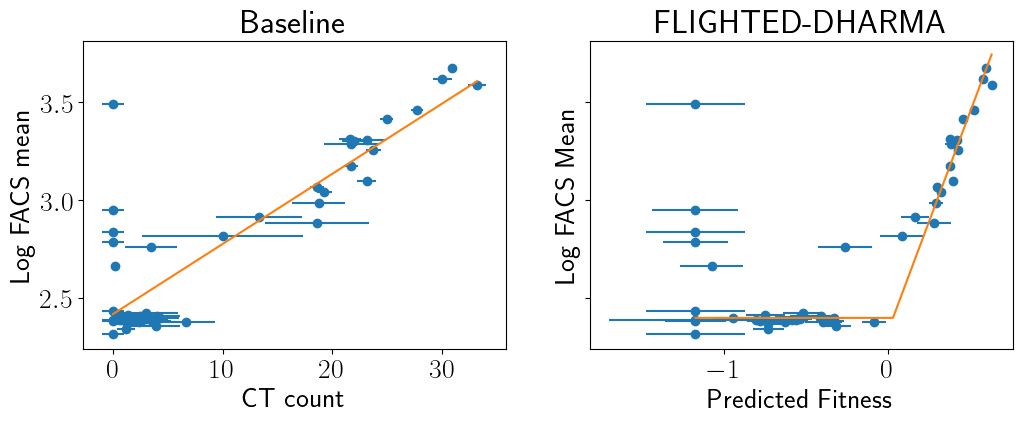

In [7]:
model = load_model()
facs_agg_df_sampled = facs_agg_df.sample(frac=0.5, random_state=0)
facs_true_means = facs_agg_df_sampled.log_fluorescence['mean'].values
facs_true_stds = facs_agg_df_sampled.log_fluorescence['sem'].values
facs_true_stds = [0 if np.isnan(val) else val for val in facs_true_stds]
facs_true_means = np.array(facs_true_means)
facs_true_stds = np.array(facs_true_stds)
dharma_ds = load_ds()
sequence_dharma_dict = {k: v[1] for k, v in zip(dharma_ds.sequences, dharma_ds)}
pred_means = []
pred_vars = []
avg_count_CTs_fluor = []
err_count_CTs_fluor = []
seqs = []
for seq in facs_agg_df_sampled.index.values:
    if seq in sequence_dharma_dict:
        mean, variance = model.infer_fitness_from_dharma(sequence_dharma_dict[seq])
        pred_means += [mean.detach().numpy()]
        pred_vars += [variance.detach().numpy()]
        count_CTs = torch.sum(sequence_dharma_dict[seq], axis=1)[:, 1].float()
        avg_count_CTs_fluor += [torch.mean(count_CTs).detach().numpy()[()]]
        if len(count_CTs) > 1 and torch.std(count_CTs).detach().numpy()[()] > 0:
            err_count_CTs_fluor += [torch.std(count_CTs).detach().numpy()[()] / np.sqrt(sequence_dharma_dict[seq].shape[0])]
        else:
            err_count_CTs_fluor += [max(1, torch.mean(count_CTs).detach().numpy()[()] / len(count_CTs))]
        seqs += [seq]
    else:
        pred_means += [np.inf]
        pred_vars += [np.inf]
        avg_count_CTs_fluor += [np.inf]
        seqs += [seq]

pred_means = np.array(pred_means)
pred_vars = np.array(pred_vars)
seqs = np.array(seqs)
avg_count_CTs_fluor = np.array(avg_count_CTs_fluor)
err_count_CTs_fluor = np.array(err_count_CTs_fluor)

mask = (pred_means != np.inf)
pred_means = pred_means[mask]
pred_vars = pred_vars[mask]
avg_count_CTs_fluor = avg_count_CTs_fluor[mask]
facs_true_means = facs_true_means[mask]
facs_true_stds = facs_true_stds[mask]
seqs = seqs[mask]

fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2, sharey='row')
ax[1].scatter(pred_means, facs_true_means)
ax[1].errorbar(pred_means, facs_true_means, xerr=np.sqrt(pred_vars), yerr=facs_true_stds, ls='None')
fluor_model, fluor_params, fluor_mse = fit_fluorescence(pred_means, pred_vars, facs_true_means, facs_true_stds)
xvals = np.linspace(min(pred_means), max(pred_means), num=1000)
ax[1].plot(xvals, fluor_model(fluor_params, xvals), label=f'MSE: {round(fluor_mse, 3)}')
ax[1].set_xlabel('Predicted Fitness')
ax[1].set_ylabel('Log FACS Mean')
ax[1].set_title('FLIGHTED-DHARMA')

ax[0].scatter(avg_count_CTs_fluor, facs_true_means)
ax[0].errorbar(avg_count_CTs_fluor, facs_true_means, xerr=err_count_CTs_fluor, yerr=facs_true_stds, ls='None')
fluor_model, fluor_params, fluor_mse = fit_fluorescence(avg_count_CTs_fluor, np.square(err_count_CTs_fluor), facs_true_means, facs_true_stds)
xvals = np.linspace(min(avg_count_CTs_fluor), max(avg_count_CTs_fluor), num=1000)
ax[0].plot(xvals, fluor_model(fluor_params, xvals), label=f'MSE: {round(fluor_mse, 3)}')
ax[0].set_xlabel('CT count')
ax[0].set_ylabel('Log FACS mean')
ax[0].set_title('Baseline')

fluor_model_ML, fluor_params_ML, fluor_mse = fit_fluorescence(pred_means, pred_vars, facs_true_means, facs_true_stds)
model_errs_ML, pred_errs_ML, mask_ML = compute_errors(pred_means, np.sqrt(pred_vars), facs_true_means, fluor_model_ML, fluor_params_ML)
fluor_model_CT, fluor_params_CT, fluor_mse = fit_fluorescence(avg_count_CTs_fluor, np.square(err_count_CTs_fluor), facs_true_means, facs_true_stds)
model_errs_CT, pred_errs_CT, mask_CT = compute_errors(avg_count_CTs_fluor, err_count_CTs_fluor, facs_true_means, fluor_model_CT, fluor_params_CT)
combined_mask = (mask_ML) & (mask_CT)
log_prob_ML = np.mean(stats.norm.logpdf(model_errs_ML[combined_mask] / pred_errs_ML[combined_mask]))
log_prob_CT = np.mean(stats.norm.logpdf(model_errs_CT[combined_mask] / pred_errs_CT[combined_mask]))

ML: 0.0727110985572145
CT: 0.07782243834072315
ML: -10.045897812898165
CT: -19.839721008489303


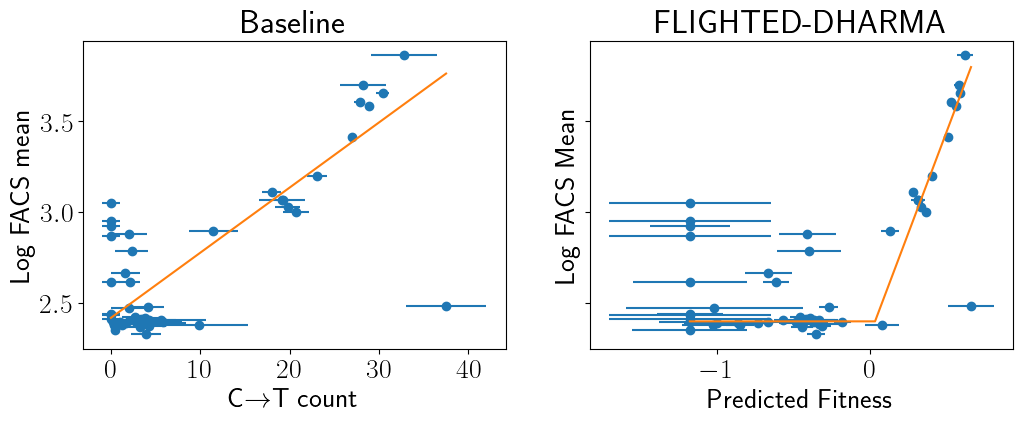

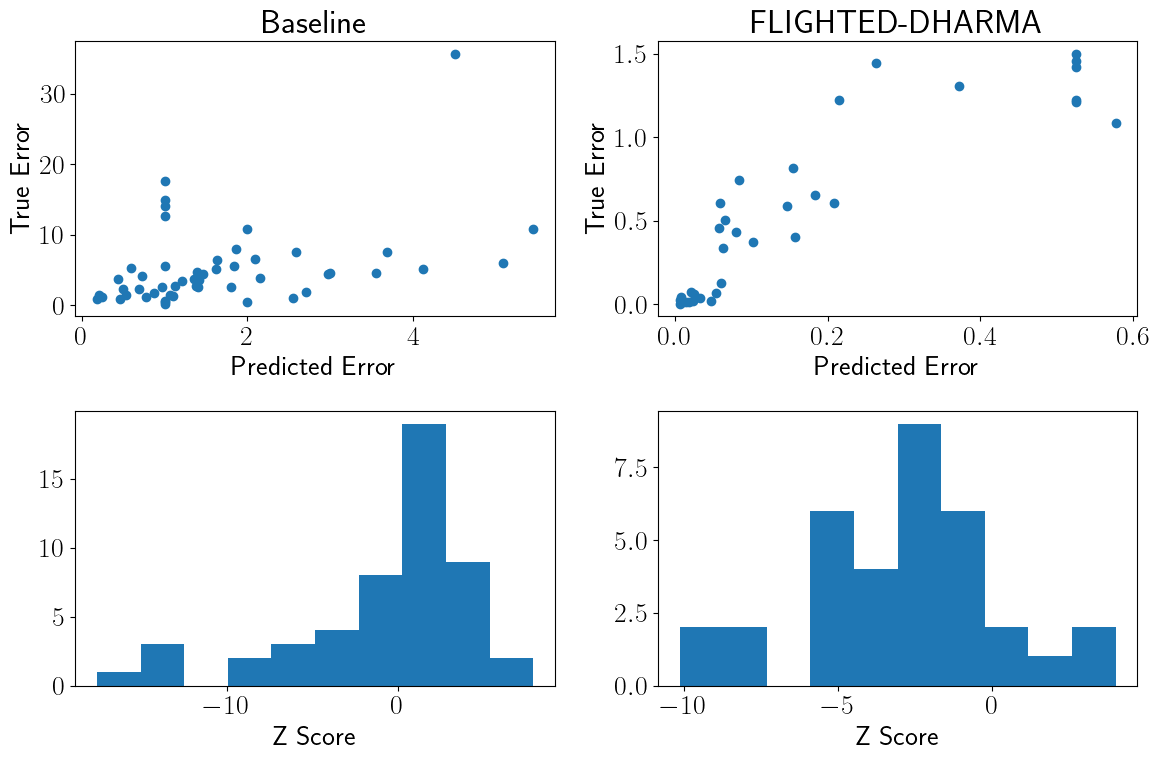

In [8]:
facs_agg_df_test = facs_agg_df[[val not in facs_agg_df_sampled.index.values for val in facs_agg_df.index]]
facs_true_means = facs_agg_df_test.log_fluorescence['mean'].values
facs_true_stds = facs_agg_df_test.log_fluorescence['sem'].values
facs_true_stds = [0 if np.isnan(val) else val for val in facs_true_stds]
facs_true_means = np.array(facs_true_means)
facs_true_stds = np.array(facs_true_stds)
sequence_dharma_dict = {k: v[1] for k, v in zip(dharma_ds.sequences, dharma_ds)}
pred_means = []
pred_vars = []
avg_count_CTs_fluor = []
err_count_CTs_fluor = []
seqs = []
for seq in facs_agg_df_test.index.values:
    if seq in sequence_dharma_dict:
        mean, variance = model.infer_fitness_from_dharma(sequence_dharma_dict[seq])
        pred_means += [mean.detach().numpy()]
        pred_vars += [variance.detach().numpy()]
        count_CTs = torch.sum(sequence_dharma_dict[seq], axis=1)[:, 1].float()
        avg_count_CTs_fluor += [torch.mean(count_CTs).detach().numpy()[()]]
        if len(count_CTs) > 1 and torch.std(count_CTs).detach().numpy()[()] > 0:
            err_count_CTs_fluor += [torch.std(count_CTs).detach().numpy()[()] / np.sqrt(sequence_dharma_dict[seq].shape[0])]
        else:
            err_count_CTs_fluor += [max(1, torch.mean(count_CTs).detach().numpy()[()] / len(count_CTs))]
        seqs += [seq]
    else:
        pred_means += [np.inf]
        pred_vars += [np.inf]
        avg_count_CTs_fluor += [np.inf]
        seqs += [seq]

pred_means = np.array(pred_means)
pred_vars = np.array(pred_vars)
seqs = np.array(seqs)
avg_count_CTs_fluor = np.array(avg_count_CTs_fluor)
err_count_CTs_fluor = np.array(err_count_CTs_fluor)

mask = (pred_means != np.inf)
pred_means = pred_means[mask]
pred_vars = pred_vars[mask]
avg_count_CTs_fluor = avg_count_CTs_fluor[mask]
facs_true_means = facs_true_means[mask]
facs_true_stds = facs_true_stds[mask]
seqs = seqs[mask]

fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2, sharey='row')
ax[1].scatter(pred_means, facs_true_means)
ax[1].errorbar(pred_means, facs_true_means, xerr=np.sqrt(pred_vars), yerr=facs_true_stds, ls='None')
fluor_mse = mean_squared_error(fluor_model_ML, fluor_params_ML, pred_means, np.sqrt(pred_vars), facs_true_means)
xvals = np.linspace(min(pred_means), max(pred_means), num=1000)
ax[1].plot(xvals, fluor_model_ML(fluor_params_ML, xvals))
ax[1].set_xlabel('Predicted Fitness')
ax[1].set_ylabel('Log FACS Mean')
ax[1].set_title('FLIGHTED-DHARMA')
print(f'ML: {fluor_mse}')

ax[0].scatter(avg_count_CTs_fluor, facs_true_means)
ax[0].errorbar(avg_count_CTs_fluor, facs_true_means, xerr=err_count_CTs_fluor, yerr=facs_true_stds, ls='None')
fluor_mse = mean_squared_error(fluor_model_CT, fluor_params_CT, avg_count_CTs_fluor, err_count_CTs_fluor, facs_true_means)
xvals = np.linspace(min(avg_count_CTs_fluor), max(avg_count_CTs_fluor), num=1000)
ax[0].plot(xvals, fluor_model_CT(fluor_params_CT, xvals))
ax[0].set_xlabel(r'C$\rightarrow$T count')
ax[0].set_ylabel('Log FACS mean')
ax[0].set_title('Baseline')
print(f'CT: {fluor_mse}')

model_errs_ML, pred_errs_ML, mask_ML = compute_errors(pred_means, np.sqrt(pred_vars), facs_true_means, fluor_model_ML, fluor_params_ML)
model_errs_CT, pred_errs_CT, mask_CT = compute_errors(avg_count_CTs_fluor, err_count_CTs_fluor, facs_true_means, fluor_model_CT, fluor_params_CT)
combined_mask = (mask_ML) & (mask_CT)
log_prob_ML = np.mean(stats.norm.logpdf(model_errs_ML[combined_mask] / pred_errs_ML[combined_mask]))
log_prob_CT = np.mean(stats.norm.logpdf(model_errs_CT[combined_mask] / pred_errs_CT[combined_mask]))

fig, ax = plt.subplots(figsize=(12, 8), nrows=2, ncols=2)
ax[0, 1].scatter(pred_errs_ML[mask_ML], np.abs(model_errs_ML[mask_ML]))
ax[0, 1].set_xlabel('Predicted Error')
ax[0, 1].set_ylabel('True Error')
ax[0, 1].set_title('FLIGHTED-DHARMA')

ax[1, 1].hist(model_errs_ML[mask_ML] / pred_errs_ML[mask_ML], label=f'Log likelihood: {round(log_prob_ML, 3)}')
ax[1, 1].set_xlabel('Z Score')

ax[0, 0].scatter(pred_errs_CT[mask_CT], np.abs(model_errs_CT[mask_CT]))
ax[0, 0].set_xlabel('Predicted Error')
ax[0, 0].set_ylabel('True Error')
ax[0, 0].set_title('Baseline')

ax[1, 0].hist(model_errs_CT[mask_CT] / pred_errs_CT[mask_CT], label=f'Log likelihood: {round(log_prob_CT, 3)}')
ax[1, 0].set_xlabel('Z Score')

print(f"ML: {log_prob_ML}")
print(f"CT: {log_prob_CT}")

fig.tight_layout()

-3.925724749692034


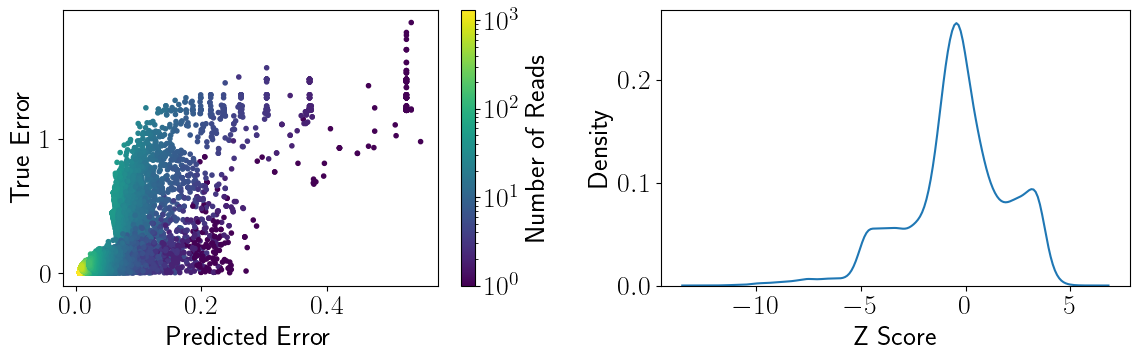

In [9]:
facs_true_means = facs_agg_df_test.log_fluorescence['mean'].values
facs_true_stds = facs_agg_df_test.log_fluorescence['sem'].values
facs_true_stds = [0 if np.isnan(val) else val for val in facs_true_stds]
facs_true_means = np.array(facs_true_means)
facs_true_stds = np.array(facs_true_stds)
pred_means = []
pred_vars = []
num_reads_all = []
seqs = []
for seq in facs_agg_df_test.index.values:
    if seq in sequence_dharma_dict:
        all_reads = sequence_dharma_dict[seq]
        num_reads = all_reads.shape[0]
        pred_means_read = []
        pred_vars_read = []
        num_reads_array = []
        for i in range(1, num_reads):
            for _ in range(10):
                perm = torch.randperm(num_reads)
                idx = perm[:i]
                subsampled_reads = all_reads[idx, :, :]
                mean, variance = model.infer_fitness_from_dharma(subsampled_reads)
                pred_means_read += [mean.detach().numpy()]
                pred_vars_read += [variance.detach().numpy()]
                num_reads_array += [i]
        pred_means += [pred_means_read]
        pred_vars += [pred_vars_read]
        num_reads_all += [num_reads_array]
        seqs += [seq]
    else:
        pred_means += [[]]
        pred_vars += [[]]
        seqs += [seq]
        num_reads_all += [[]]
        
cutoff = fluor_params_ML[1]
num_reads_max = np.max([val[-1] for val in num_reads_all if val != []])
norm = mpl.colors.LogNorm(vmin=1, vmax=num_reads_max)

fig, ax = plt.subplots(figsize=(12, 4), ncols=2)
pred_errs_all = []
true_errs_all = []
for idx, seq in enumerate(seqs):
    if pred_means[idx] != [] and facs_true_means[idx] > cutoff:
        pred_errs = np.sqrt(pred_vars[idx])
        true_errs = pred_means[idx] - ((facs_true_means[idx] - fluor_params_ML[1]) / fluor_params_ML[2] + fluor_params_ML[0])
        pred_errs_all += list(pred_errs)
        true_errs_all += list(true_errs)
        sc = ax[0].scatter(pred_errs, np.abs(true_errs), c=num_reads_all[idx], marker='.', norm=norm)
ax[0].set_xlabel('Predicted Error')
ax[0].set_ylabel('True Error')
pred_errs_all = np.array(pred_errs_all)
true_errs_all = np.array(true_errs_all)
fig.colorbar(sc, label='Number of Reads')

logprob_extended = np.mean(stats.norm.logpdf(true_errs_all / pred_errs_all))
sns.kdeplot(true_errs_all / pred_errs_all, ax=ax[1])
ax[1].set_xlabel('Z Score')
print(logprob_extended)

fig.tight_layout()

-8.004963160754867


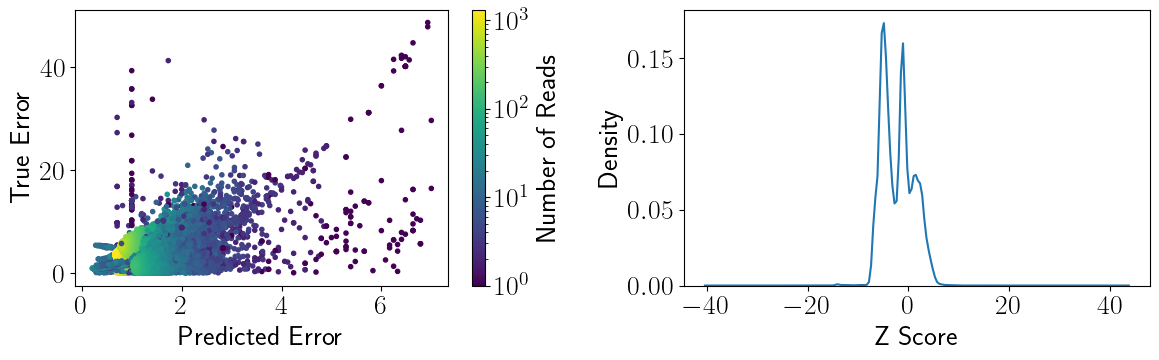

In [10]:
facs_true_means = facs_agg_df_test.log_fluorescence['mean'].values
facs_true_stds = facs_agg_df_test.log_fluorescence['sem'].values
facs_true_stds = [0 if np.isnan(val) else val for val in facs_true_stds]
facs_true_means = np.array(facs_true_means)
facs_true_stds = np.array(facs_true_stds)
pred_means = []
pred_vars = []
num_reads_all = []
seqs = []
for seq in facs_agg_df_test.index.values:
    if seq in sequence_dharma_dict:
        all_reads = sequence_dharma_dict[seq]
        num_reads = all_reads.shape[0]
        pred_means_read = []
        pred_vars_read = []
        num_reads_array = []
        for i in range(1, num_reads):
            for _ in range(10):
                perm = torch.randperm(num_reads)
                idx = perm[:i]
                subsampled_reads = all_reads[idx, :, :]
                count_CTs = torch.sum(subsampled_reads, axis=1)[:, 1].float()
                pred_means_read += [torch.mean(count_CTs).detach().numpy()[()]]
                if len(count_CTs) > 1 and torch.std(count_CTs).detach().numpy()[()] > 0:
                    pred_vars_read += [torch.std(count_CTs).detach().numpy()[()] / np.sqrt(i)]
                else:
                    pred_vars_read += [max(1, torch.mean(count_CTs).detach().numpy()[()] / len(count_CTs))]
                num_reads_array += [i]
        pred_means += [pred_means_read]
        pred_vars += [pred_vars_read]
        num_reads_all += [num_reads_array]
        seqs += [seq]
    else:
        pred_means += [[]]
        pred_vars += [[]]
        seqs += [seq]
        num_reads_all += [[]]
        
num_reads_max = np.max([val[-1] for val in num_reads_all if val != []])
norm = mpl.colors.LogNorm(vmin=1, vmax=num_reads_max)

fig, ax = plt.subplots(figsize=(12, 4), ncols=2)
pred_errs_all = []
true_errs_all = []
for idx, seq in enumerate(seqs):
    if pred_means[idx] != []:
        pred_errs = np.sqrt(pred_vars[idx])
        true_errs = pred_means[idx] - ((facs_true_means[idx] - fluor_params_CT.intercept) / fluor_params_CT.slope)
        pred_errs_all += list(pred_errs)
        true_errs_all += list(true_errs)
        sc = ax[0].scatter(pred_errs, np.abs(true_errs), c=num_reads_all[idx], marker='.', norm=norm)
ax[0].set_xlabel('Predicted Error')
ax[0].set_ylabel('True Error')
pred_errs_all = np.array(pred_errs_all)
true_errs_all = np.array(true_errs_all)
fig.colorbar(sc, label='Number of Reads')

logprob_extended = np.mean(stats.norm.logpdf(true_errs_all / pred_errs_all))
sns.kdeplot(true_errs_all / pred_errs_all, ax=ax[1])
ax[1].set_xlabel('Z Score')
print(logprob_extended)

fig.tight_layout()

In [11]:
def compute_edit_probs(fitness):
    fitness_adj = model.dharma_model.slope_edits[None, :] * fitness[:, None] + model.dharma_model.baseline_edits[None, :]
    logits = torch.zeros(fitness.shape[0], model.hparams["num_residues"], 3)
    logits[:, :, 2] = model.dharma_model.mutation_rates
    logits[:, :, 1] = -np.inf
    logits[:, model.hparams["cytosine_residues"], 1] = fitness_adj
    probs = torch.nn.functional.softmax(logits, dim=2)
    return logits, probs

Text(0, 0.5, 'C$\\rightarrow$T Mutations')

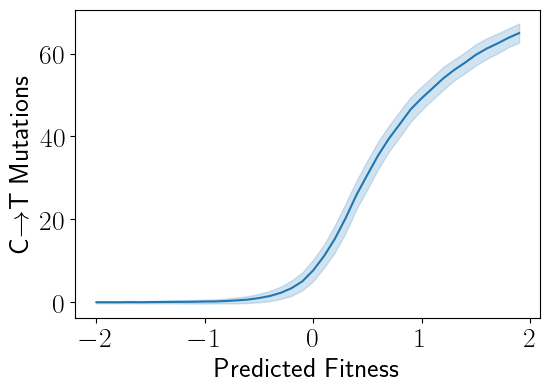

In [12]:
xvals = torch.arange(-2, 2, 0.1)
num_samples = 1000
_, probs = compute_edit_probs(xvals)
samples = torch.distributions.Multinomial(probs=probs).sample([num_samples]).transpose(0, 1)
CT_mutation_count = torch.sum(samples[:, :, :, 1], axis=2)
prob_fitness_dict = {'fitness': [], 'num_CT': []}
for i, fitness in enumerate(xvals):
    prob_fitness_dict['fitness'] += list(fitness.detach().numpy()[()] * np.array([1 for _ in range(num_samples)]))
    prob_fitness_dict['num_CT'] += list(CT_mutation_count[i, :].detach().numpy())
prob_fitness_df = pd.DataFrame(prob_fitness_dict)

fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(data=prob_fitness_df, x='fitness', y='num_CT', ax=ax, err_style='band', errorbar='sd')
ax.set_xlabel('Predicted Fitness')
ax.set_ylabel(r'C$\rightarrow$T Mutations')

Text(0, 0.5, 'Logit of C$\\rightarrow$T Edit')

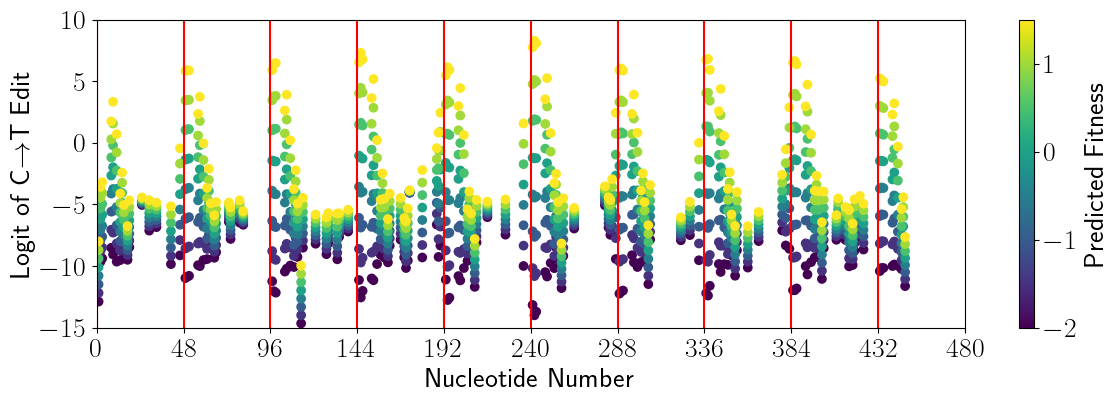

In [13]:
test_fitnesses = torch.arange(-2, 2, 0.5)
logits, _ = compute_edit_probs(test_fitnesses)
logits_reshaped = logits[:, model.hparams['cytosine_residues'], 1].detach().numpy().reshape((-1,))
residues = np.tile(model.hparams['cytosine_residues'], len(test_fitnesses))
test_fitnesses_repeated = np.repeat(test_fitnesses.detach().numpy(), len(model.hparams['cytosine_residues']))

max_repeats = 10

fig, ax = plt.subplots(figsize=(14, 4))
cmap = ax.scatter(residues, logits_reshaped, c=test_fitnesses_repeated)
ax.set_xticks([48*n for n in range(max_repeats+1)])
ax.vlines([48*n for n in range(max_repeats)], -50, 50, colors='red')
ax.set_xlim([0, 48*max_repeats])
ax.set_ylim([-15, 10])
fig.colorbar(cmap, label="Predicted Fitness")
ax.set_xlabel('Nucleotide Number')
ax.set_ylabel(r'Logit of C$\rightarrow$T Edit')

In [14]:
seq_to_count_CTs = {}

for seq, data in tqdm(zip(dharma_ds.sequences, dharma_ds)):
    if seq in facs_agg_df.index.values:
        count_CTs = data[1][:, :, 1].sum(axis=1).to(torch.float32)
        seq_to_count_CTs[seq] = count_CTs

0it [00:00, ?it/s]

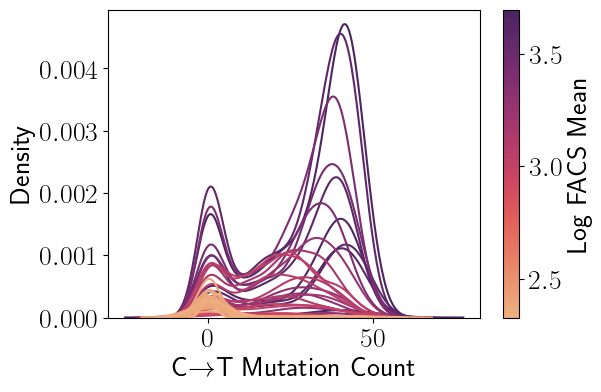

In [15]:
CT_fluor_dict = {'count_CT': [], 'fluorescence': []}
for seq, count_CTs in seq_to_count_CTs.items():
    if len(count_CTs) > 20:
        fluorescence = facs_agg_df.loc[seq].log_fluorescence['mean']
        CT_fluor_dict['count_CT'] += list(count_CTs.detach().numpy())
        CT_fluor_dict['fluorescence'] += list(fluorescence * torch.ones_like(count_CTs).detach().numpy())
CT_fluor_df = pd.DataFrame(CT_fluor_dict)

fig, ax = plt.subplots(figsize=(6, 4))
norm = plt.Normalize(min(CT_fluor_dict['fluorescence']), max(CT_fluor_dict['fluorescence']))
sm = plt.cm.ScalarMappable(cmap='flare', norm=norm)
sns.kdeplot(data=CT_fluor_df, x='count_CT', hue='fluorescence', palette='flare')
ax.set_xlabel(r'C$\rightarrow$T Mutation Count')
ax.get_legend().remove()
fig.colorbar(sm, ax=ax, label='Log FACS Mean')